In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import XGBModel, LinearRegressionModel, CatBoostModel
from scipy.optimize import brentq
import pdb

In [2]:
# Read and process the dataframes
cases_data = pd.read_csv('cases_1to4wk.csv').drop('Unnamed: 0', axis=1)
cases_data = cases_data.rename({'forecast_0.1' : 'cases_forecast_0.1', 'forecast_0.9' : 'cases_forecast_0.9', 'actual' : 'actual_cases'}, axis=1)
deaths_data = pd.read_csv('deaths_1to4wk.csv').drop('Unnamed: 0', axis=1)
deaths_data = deaths_data.rename({'forecast_0.1' : 'deaths_forecast_0.1', 'forecast_0.9' : 'deaths_forecast_0.9', 'actual' : 'actual_deaths'}, axis=1)
# Merge the dataframes on 'target_end_date' and 'ahead'
df = pd.merge(cases_data, deaths_data, on=['target_end_date', 'ahead', 'forecast_date'])
df['target_end_date'] = df['target_end_date'].astype('datetime64[ns]')
df['forecast_date'] = df['forecast_date'].astype('datetime64[ns]')

In [3]:
# Calculate score functions
df['cases_score_upper'] =  (df['actual_cases'] - df['cases_forecast_0.9'])  / df['actual_cases']
df['cases_score_lower'] =  (df['cases_forecast_0.1'] - df['actual_cases'])  / df['actual_cases']
df['deaths_score_upper'] = (df['actual_deaths'] - df['deaths_forecast_0.9']) /10000      #/ df['actual_deaths']
df['deaths_score_lower'] = (df['deaths_forecast_0.1'] - df['actual_deaths']) /10000      #/ df['actual_deaths']

<AxesSubplot:xlabel='target_end_date', ylabel='cases_score_upper'>

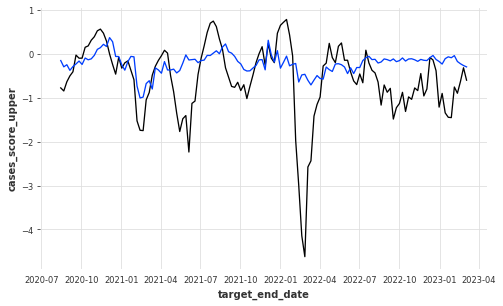

In [4]:
# Plot score functions
plt.figure(figsize=(8,4.8))
sns.lineplot(data=df[df.ahead == 4], x='target_end_date', y='cases_score_upper')
sns.lineplot(data=df[df.ahead == 4], x='target_end_date', y='deaths_score_upper')

<AxesSubplot:xlabel='target_end_date', ylabel='cases_score_lower'>

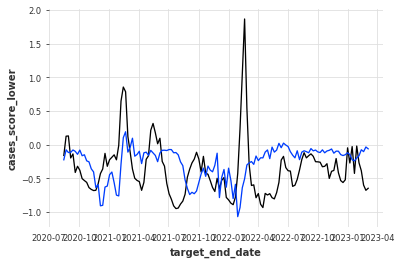

In [5]:
# Plot score functions
sns.lineplot(data=df[df.ahead == 4], x='target_end_date', y='cases_score_lower')
sns.lineplot(data=df[df.ahead == 4], x='target_end_date', y='deaths_score_lower')

In [6]:
# Create TimeSeries objects
df_4wk = df[df.ahead == 4].dropna()
cases_series_upper = TimeSeries.from_dataframe(df_4wk, time_col='target_end_date', value_cols='cases_score_upper')
deaths_series_upper = TimeSeries.from_dataframe(df_4wk, time_col='target_end_date', value_cols='deaths_score_upper')

model_upper = CatBoostModel(lags=[-4, -5, -6], lags_past_covariates=1, likelihood='quantile', quantiles=[0.1, 0.5, 0.90])

# Perform the backtesting
past_covariates_upper = cases_series_upper.shift(4)  # Shift the cases data by 4 periods
death_score_upper_forecasts = model_upper.historical_forecasts(deaths_series_upper, past_covariates = past_covariates_upper, num_samples=50)

In [35]:
# Create TimeSeries objects
df_4wk = df[df.ahead == 4].dropna()
cases_series_lower = TimeSeries.from_dataframe(df_4wk, time_col='target_end_date', value_cols='cases_score_lower')
deaths_series_lower = TimeSeries.from_dataframe(df_4wk, time_col='target_end_date', value_cols='deaths_score_lower')

model_lower = CatBoostModel(lags=[-4, -5, -6], lags_past_covariates=1, likelihood='quantile', quantiles=[0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.90, 0.95, 0.975])

# Perform the backtesting
past_covariates_lower = cases_series_lower.shift(4)  # Shift the cases data by 1 period
death_score_lower_forecasts = model_lower.historical_forecasts(deaths_series_lower, past_covariates = past_covariates_lower, num_samples=50)

In [25]:
# Process the forecasts
#death_score_upper_quantile = death_score_upper_forecasts.quantile(0.9)
#death_score_lower_quantile = death_score_lower_forecasts.quantile(0.9)
#def postprocess(q0, s0, q1, s1):
#    merged0 = q0.pd_dataframe().rename_axis('target_end_date', axis='index').merge(s0.pd_dataframe(), on='target_end_date')
#    merged1 = q1.pd_dataframe().rename_axis('target_end_date', axis='index').merge(s1.pd_dataframe(), on='target_end_date')
#    # Pick a constant such that the previous scorecasts were larger than the scores 90% of the time historically
#    c0s = np.zeros((len(q0),))
#    c1s = np.zeros((len(q0),))
#    for t in range(len(q0)):
#        def to_invert_0(c):
#            cvd = (merged0['deaths_score_lower'] <= (merged0['deaths_score_lower_0.9'] + c)).head(max(t-4,0))
#            should_be_zero = cvd.mean() - 0.9
#            return should_be_zero
#        c0s[t] = brentq(to_invert_0, -100, 100) if t >= 4 else 0
#        def to_invert_1(c):
#            cvd = (merged1['deaths_score_upper'] <= (merged1['deaths_score_upper_0.9'] + c)).head(max(t-4,0))
#            should_be_zero = cvd.mean() - 0.9
#            return should_be_zero
#        c1s[t] = brentq(to_invert_1, -100, 100) if t >= 4 else 0
#    merged0['deaths_score_lower_0.9'] += c0s
#    merged1['deaths_score_upper_0.9'] += c1s
#
#    proc_death_score_lower_quantile = TimeSeries.from_dataframe(merged0, value_cols='deaths_score_lower_0.9')
#    proc_death_score_upper_quantile = TimeSeries.from_dataframe(merged1, value_cols='deaths_score_upper_0.9')
#    return proc_death_score_lower_quantile, proc_death_score_upper_quantile
#
#death_score_upper_quantile = TimeSeries.from_dataframe(death_score_upper_quantile.pd_dataframe().rename_axis('target_end_date', axis='index'))#post_process(death_score_upper_quantile)
#death_score_lower_quantile = TimeSeries.from_dataframe(death_score_lower_quantile.pd_dataframe().rename_axis('target_end_date', axis='index'))#post_process(death_score_lower_quantile)
#proc_death_score_lower_quantile, proc_death_score_upper_quantile = postprocess(death_score_lower_quantile, deaths_series_lower, death_score_upper_quantile, deaths_series_upper)

In [36]:
proc_death_score_upper_quantile = TimeSeries.from_dataframe(death_score_upper_quantile.pd_dataframe().rename_axis('target_end_date', axis='index'))#post_process(death_score_upper_quantile)
proc_death_score_lower_quantile = TimeSeries.from_dataframe(death_score_lower_quantile.pd_dataframe().rename_axis('target_end_date', axis='index'))#post_process(death_score_lower_quantile)

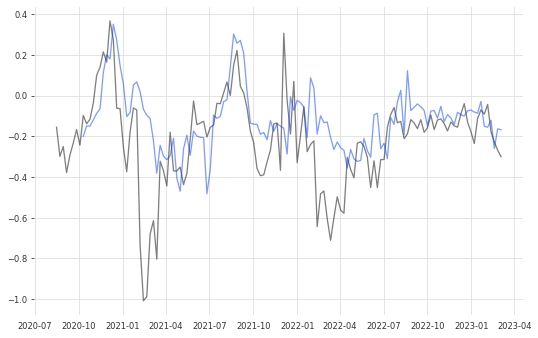

In [37]:
plt.figure(figsize=(7.6,4.8))
plt.plot(np.array(deaths_series_upper._time_index), deaths_series_upper.values(), alpha=0.5)
plt.plot(np.array(proc_death_score_upper_quantile.time_index), proc_death_score_upper_quantile.values(), alpha=0.5)
plt.tight_layout()

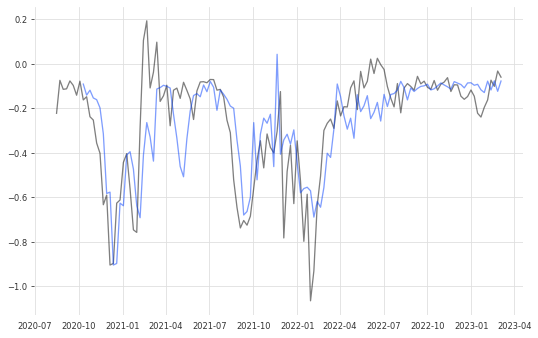

In [38]:
plt.figure(figsize=(7.6,4.8))
plt.plot(np.array(deaths_series_lower._time_index), deaths_series_lower.values(), alpha=0.5)
plt.plot(np.array(death_score_lower_quantile.time_index), proc_death_score_lower_quantile.values(), alpha=0.5)
plt.tight_layout()

In [39]:
# Create a dataset for use with the base framework
dataset = deaths_series_lower.pd_dataframe().rename({'deaths_score_lower' : 'score_lower'}, axis=1).merge(
    deaths_series_upper.pd_dataframe().rename({'deaths_score_upper' : 'score_upper'}, axis=1), on='target_end_date').merge(
    proc_death_score_lower_quantile.pd_dataframe().rename({'deaths_score_lower_0.9' : 'scorecast_lower', 'deaths_score_lower' : 'scorecast_lower'}, axis=1), on='target_end_date').merge(
    proc_death_score_upper_quantile.pd_dataframe().rename({'deaths_score_upper_0.9' : 'scorecast_upper', 'deaths_score_upper' : 'scorecast_upper'}, axis=1), on='target_end_date').astype(float)
dataset = dataset.merge(df[df.ahead == 4].drop(['actual_cases', 'cases_forecast_0.1', 'cases_forecast_0.9', 'ahead', 'cases_score_upper', 'cases_score_lower', 'deaths_score_upper', 'deaths_score_lower'], axis=1), on='target_end_date')

dataset['scores'] = [np.array([dataset['score_lower'][j]*10000, dataset['score_upper'][j]*10000]) for j in range(len(dataset))]
dataset['scorecasts'] = [np.array([dataset['scorecast_lower'][j]*10000, dataset['scorecast_upper'][j]*10000]) for j in range(len(dataset))]
dataset['forecasts'] = [np.array([dataset['deaths_forecast_0.1'][j], dataset['deaths_forecast_0.9'][j]]) for j in range(len(dataset))]
dataset = dataset.drop(['score_lower', 'score_upper', 'scorecast_lower', 'scorecast_upper', 'deaths_forecast_0.1', 'deaths_forecast_0.9', 'forecast_date'], axis=1).rename({'target_end_date' : 'timestamp', 'actual_deaths' : 'y'}, axis=1).melt(id_vars=['timestamp'], value_name='target')

In [40]:
dataset.to_pickle('./proc_4wkdeaths.pkl')